# Library Usage Examples

author: camen  
last run: Apr 19, 2020

In [1]:
import datetime
import glob
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from wildfire import wildfire
from wildfire.data import goes_level_1

LOCAL_DIRECTORY = "temporary_output"

logging.basicConfig(level=logging.INFO)

## Introduction

This library provides useful wrappers around NOAA's GOES-R series satellite data hosted in Amazon S3. This notebook provides some example usage of various parts of the library.

## Contents

1. [Downloading](#Downloading)
2. [GoesBand](#GoesBand)
3. [GoesScan](#GoesScan)
5. [Wildfire Detection](#Wildfire-Detection)

## Downloading

In [2]:
s3_scan_files = goes_level_1.downloader.list_s3_files(
    satellite="noaa-goes17",
    region="M1",
    start_time=datetime.datetime(2019, 1, 1, 1, 1),
    end_time=None
)

INFO:wildfire.data.goes_level_1.downloader:Listing files in S3 using glob patterns: ['noaa-goes17/ABI-L1b-RadM/2019/001/01/OR_ABI-L1b-RadM1-M?C??_G17_s20190010101*.nc']
2020-04-19 16:24:52,075	INFO resource_spec.py:212 -- Starting Ray with 2.29 GiB memory available for workers and up to 1.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-19 16:24:52,407	INFO services.py:1148 -- View the Ray dashboard at 127.0.0.1:8265
INFO:wildfire.multiprocessing:Using 4 workers to run <lambda> with args of shape (1, 1)...


### Single File

In [3]:
local_filepath = goes_level_1.downloader.download_file(
    s3_filepath=s3_scan_files[0], 
    local_directory=LOCAL_DIRECTORY
)

In [4]:
xr.open_dataset(local_filepath)

<xarray.Dataset>
Dimensions:                                 (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 1000, y: 1000)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1484 ... 0.120427996
  * x                                       (x) float32 -0.03864 ... -0.010668
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) int8 ...
    band_wavelength                         (band) float32 ...
    t_star_look                             (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look               (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    Rad                                     (y, x) float32 ...
    DQF                              

### Multiple Files

In [5]:
local_filepaths = goes_level_1.downloader.download_files(
    local_directory=LOCAL_DIRECTORY,
    satellite="noaa-goes17",
    region="M1",
    start_time=datetime.datetime(2019, 10, 27, 10, 0),
    end_time=datetime.datetime(2019, 10, 27, 10, 2)
)

INFO:wildfire.data.goes_level_1.downloader:Listing files in S3 using glob patterns: ['noaa-goes17/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M?C??_G17_s**.nc']
INFO:wildfire.multiprocessing:Using 4 workers to run <lambda> with args of shape (1, 1)...


download files..


INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...
INFO:wildfire.data.goes_level_1.downloader:Downloading 0 files using 4 workers...
INFO:wildfire.multiprocessing:Using 4 workers to run _download_file_mp with args of shape (0,)...
INFO:wildfire.data.goes_level_1.downloader:Downloaded 0.00000 GB of satellite data.


In [6]:
local_filepaths

['temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C01_G17_s20193001000275_e20193001000332_c20193001000375.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C01_G17_s20193001001275_e20193001001332_c20193001001381.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C02_G17_s20193001000275_e20193001000332_c20193001000359.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C02_G17_s20193001001275_e20193001001332_c20193001001362.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C03_G17_s20193001000275_e20193001000332_c20193001000380.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C03_G17_s20193001001275_e20193001001332_c20193001001375.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C04_G17_s20193001000275_e20193001000332_c20193001000362.nc',
 'temporary_output/ABI-L1b-RadM/2019/300/10/OR_ABI-L1b-RadM1-M6C04_G17_s20193001001275_e20193001001332_c20193001001387.nc',
 'tempor

## GoesBand

### From local filepath

In [7]:
goes_band = goes_level_1.read_netcdf(local_filepath=sorted(local_filepaths)[12])

print("Available methods for `GoesBand` object:")
[method for method in dir(goes_band) if not method.startswith("__")]

Available methods for `GoesBand` object:


['band_id',
 'band_wavelength_micrometers',
 'brightness_temperature',
 'dataset',
 'filter_bad_pixels',
 'normalize',
 'parse',
 'plot',
 'reflectance_factor',
 'region',
 'rescale_to_2km',
 'satellite',
 'scan_time_utc',
 'to_netcdf']

### From S3 query

In [8]:
goes_band = goes_level_1.get_goes_band(
    satellite="noaa-goes16",
    region="M1",
    channel=3,
    scan_time_utc=datetime.datetime(2019, 5, 10, 10, 30),
    local_directory=LOCAL_DIRECTORY
)

goes_band

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


GoesBand(satellite=G16, region=M1, band=3, wavelength=0.87µm, scan_time=2019-05-10T10:30:38)

### From local query

In [9]:
goes_band = goes_level_1.get_goes_band(
    satellite="noaa-goes16",
    region="M1",
    channel=3,
    scan_time_utc=datetime.datetime(2019, 5, 10, 10, 30),
    local_directory=LOCAL_DIRECTORY,
    s3=False
)

goes_band

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


GoesBand(satellite=G16, region=M1, band=3, wavelength=0.87µm, scan_time=2019-05-10T10:30:38)

### Plotting

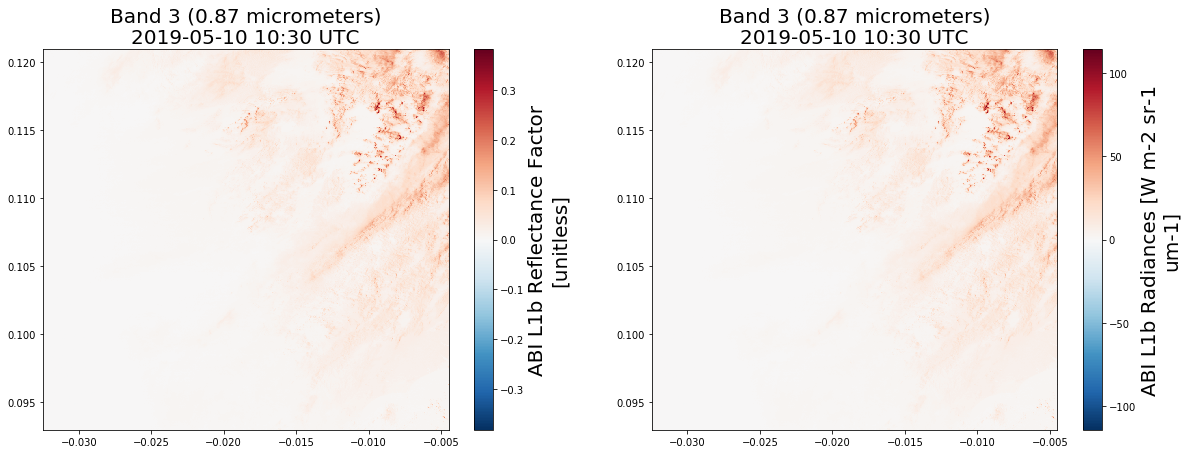

In [10]:
_, axes = plt.subplots(ncols=2, figsize=(20, 7))
goes_band.plot(axis=axes[0]);
goes_band.plot(axis=axes[1], use_radiance=True);

## GoesScan

### From local filepaths

In [11]:
local_scan_filepaths = goes_level_1.utilities.list_local_files(
    local_directory=LOCAL_DIRECTORY,
    satellite="noaa-goes17",
    region="M1",
    start_time=datetime.datetime(2019, 10, 27, 10, 1)
)
goes_scan = goes_level_1.read_netcdfs(local_filepaths=local_scan_filepaths)

print("Available methods for `GoesScan` object:")
[method for method in dir(goes_scan) if not method.startswith("__")]

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


Available methods for `GoesScan` object:


['_parse_input',
 'bands',
 'iteritems',
 'keys',
 'plot',
 'region',
 'rescale_to_2km',
 'satellite',
 'scan_time_utc',
 'to_netcdf']

### From S3 query

In [12]:
goes_scan = goes_level_1.get_goes_scan(
    satellite="noaa-goes16",
    region="M1",
    scan_time_utc=datetime.datetime(2018, 11, 13, 5, 30),
    local_directory=LOCAL_DIRECTORY
)

goes_scan

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


GoesScan(satellite=G16, region=M1, scan_time=2018-11-13T05:30:24)

### From local query

In [13]:
goes_scan = goes_level_1.get_goes_scan(
    satellite="noaa-goes16",
    region="M1",
    scan_time_utc=datetime.datetime(2018, 11, 13, 5, 30),
    local_directory=LOCAL_DIRECTORY,
    s3=False
)

goes_scan

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


GoesScan(satellite=G16, region=M1, scan_time=2018-11-13T05:30:24)

### Plotting

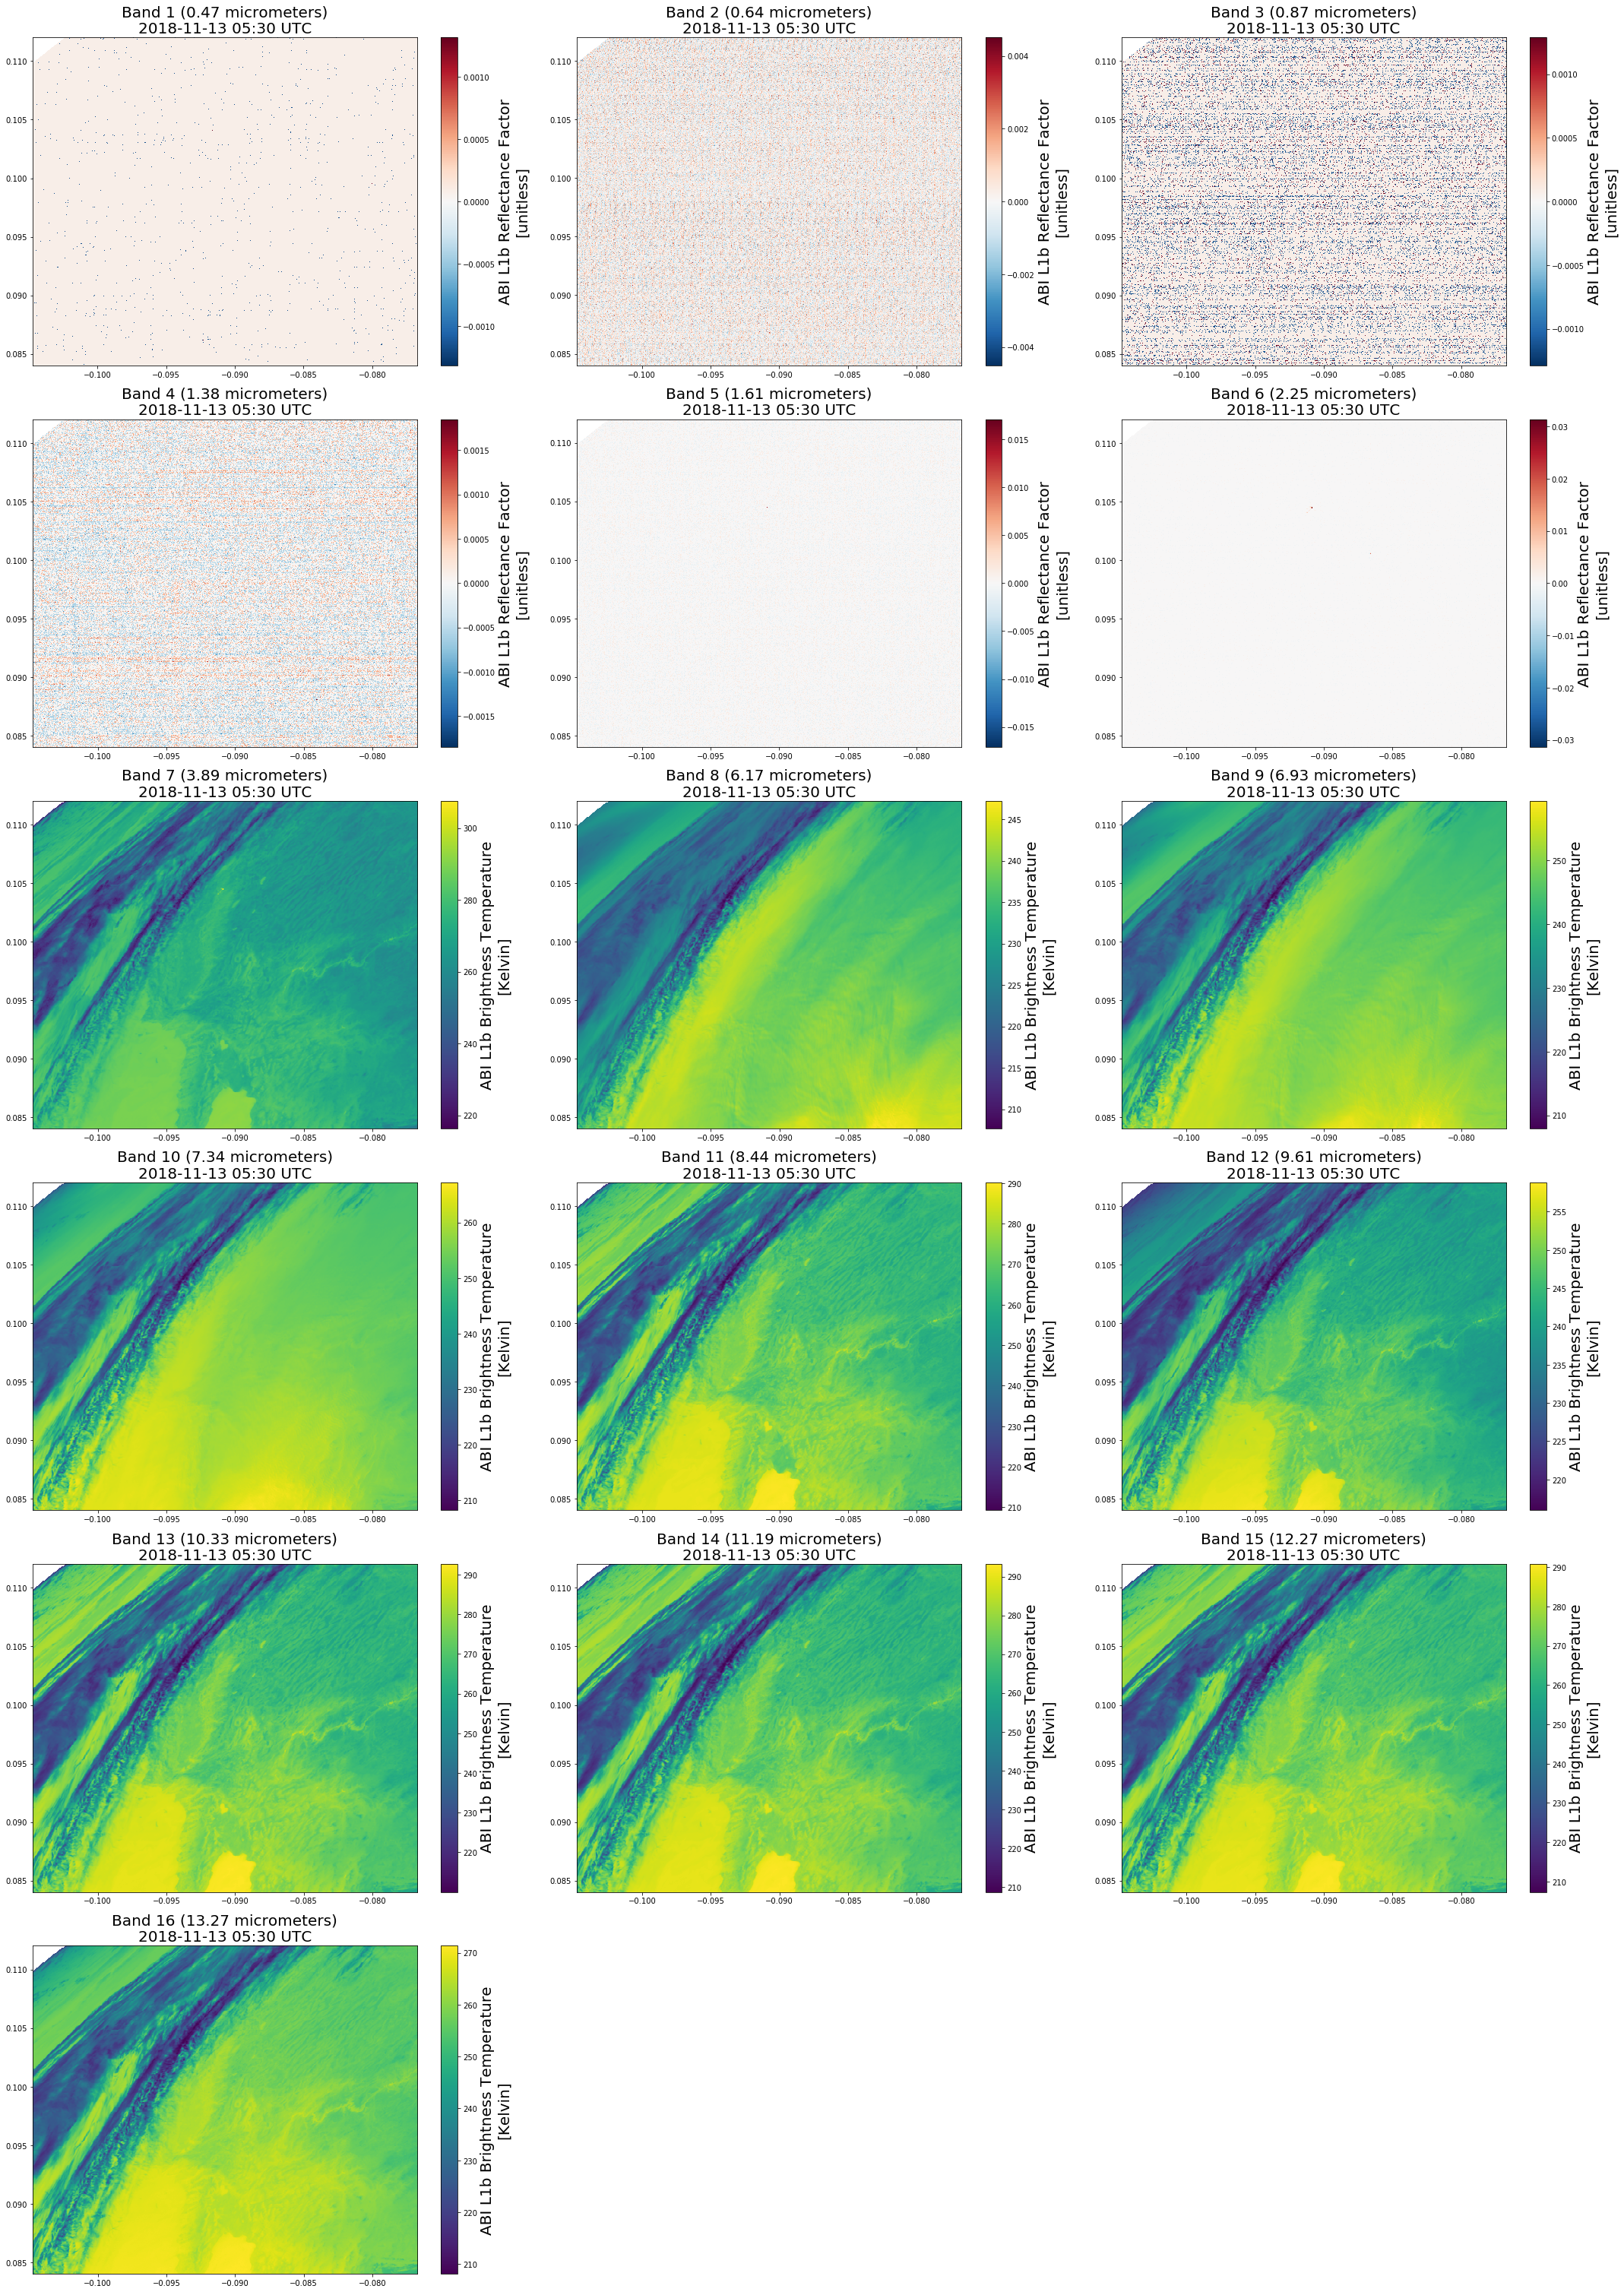

In [14]:
goes_scan.plot();

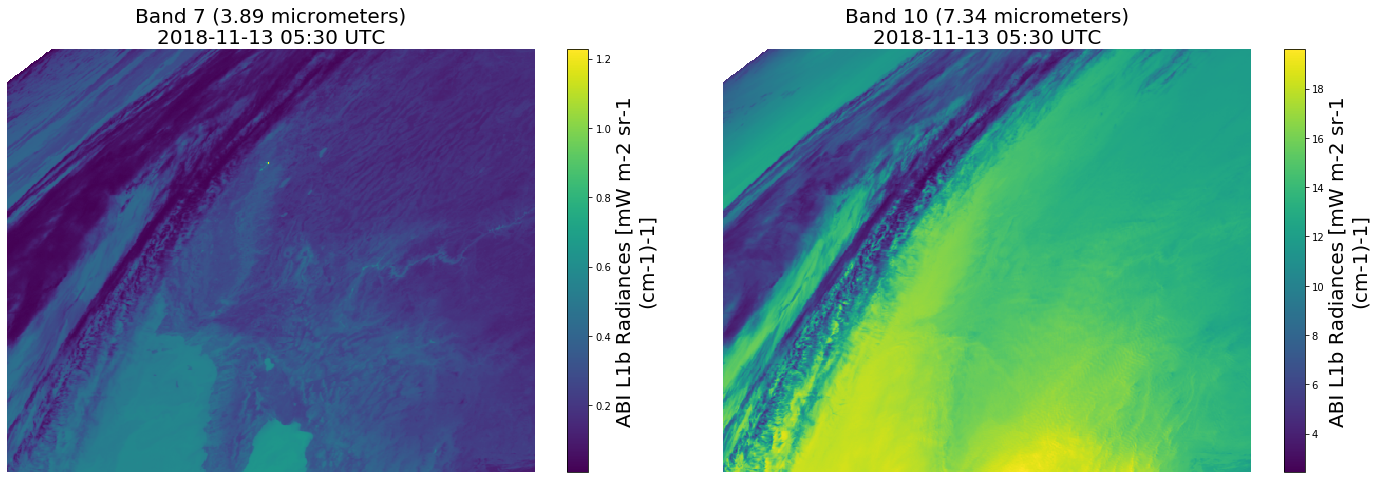

In [15]:
goes_scan.plot(bands=[7, 10], use_radiance=True);

## Wildfire Detection

In [16]:
goes_scan_wildfire = goes_level_1.get_goes_scan(
    satellite="noaa-goes17",
    region="M1",
    scan_time_utc=datetime.datetime(2019, 10, 27, 10, 0),
    local_directory=LOCAL_DIRECTORY
)

goes_scan_no_wildfire = goes_level_1.get_goes_scan(
    satellite="noaa-goes16",
    region="M1",
    scan_time_utc=datetime.datetime(2018, 11, 13, 5, 30),
    local_directory=LOCAL_DIRECTORY,
    s3=False
)

INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...
INFO:wildfire.multiprocessing:Using 4 workers to run glob with args of shape (1, 1)...


In [17]:
print(goes_scan_wildfire)

predictions = wildfire.predict_wildfires_goes(goes_scan=goes_scan_wildfire)
display(predictions)
print(predictions.mean() > 0)

GoesScan(satellite=G17, region=M1, scan_time=2019-10-27T10:00:27)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

True


In [18]:
print(goes_scan_no_wildfire)

predictions = wildfire.predict_wildfires_goes(goes_scan=goes_scan_no_wildfire)
display(predictions)
print(predictions.mean() > 0)

GoesScan(satellite=G16, region=M1, scan_time=2018-11-13T05:30:24)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

False


### Plotting

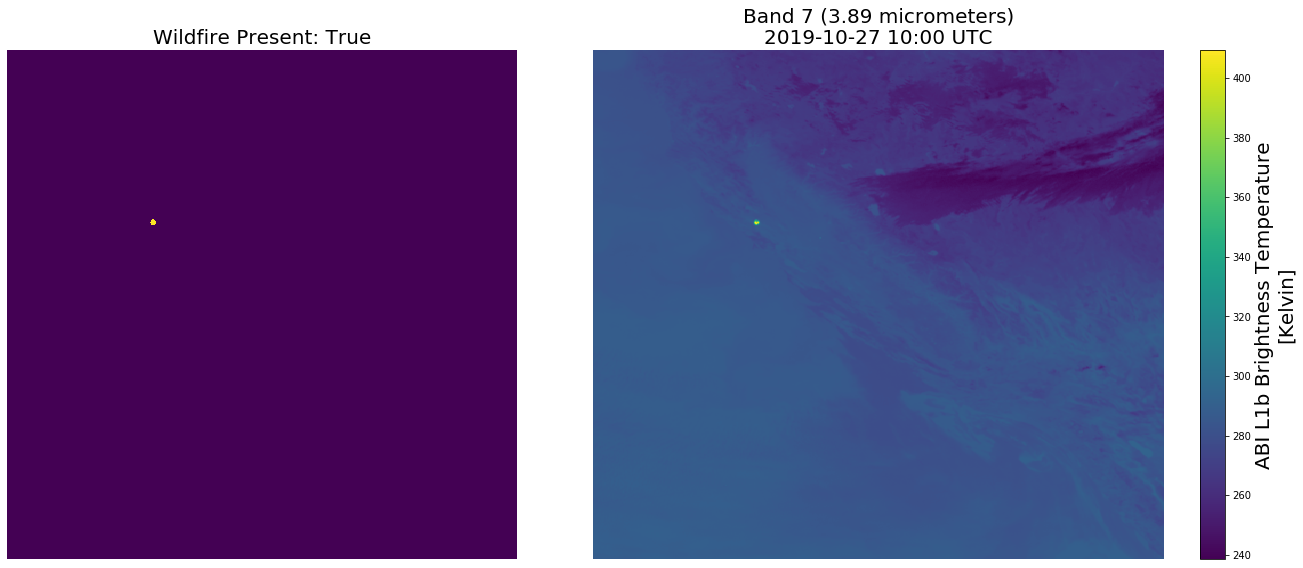

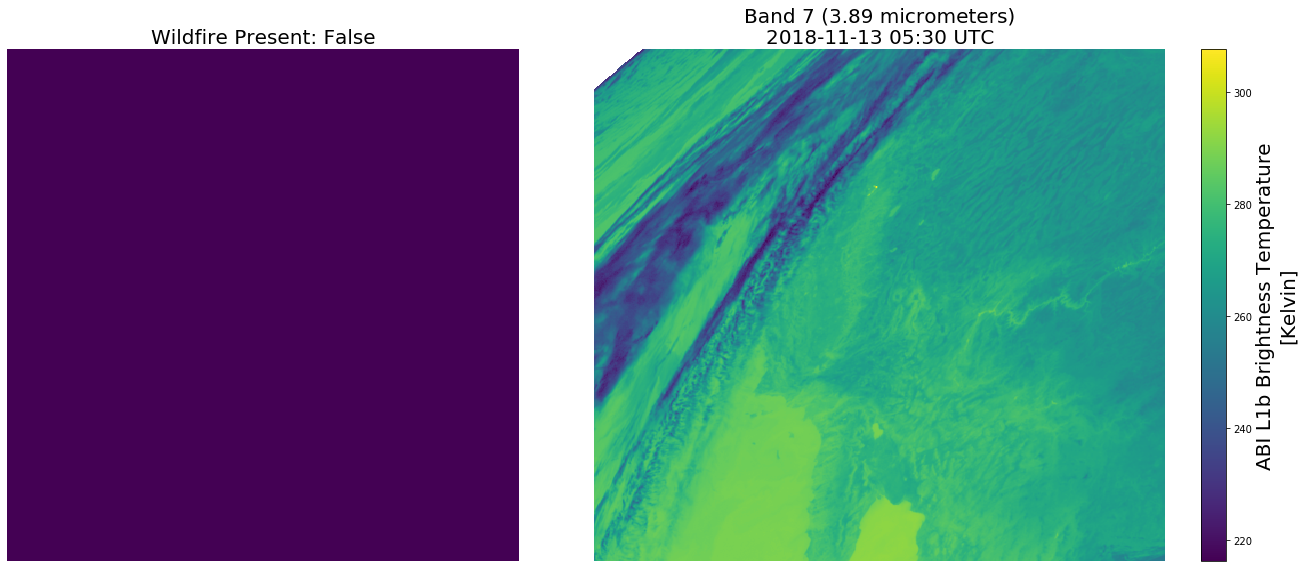

In [19]:
wildfire.plot_wildfires_goes(goes_scan=goes_scan_wildfire);
wildfire.plot_wildfires_goes(goes_scan=goes_scan_no_wildfire);

### Model features

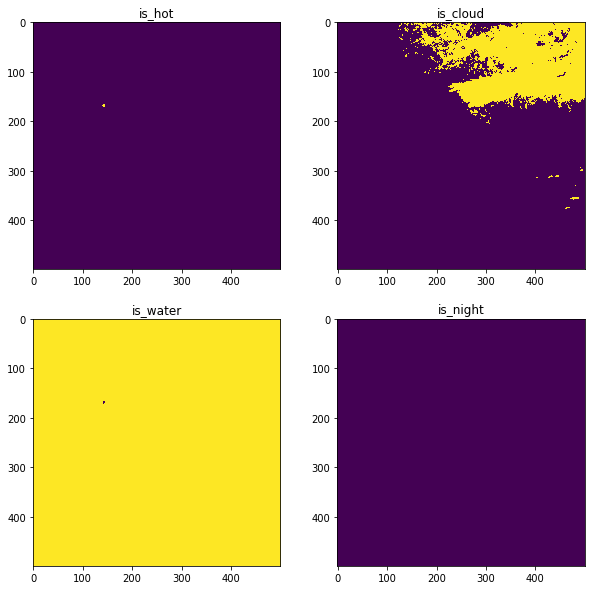

In [20]:
model_features = wildfire.get_model_features_goes(goes_scan=goes_scan_wildfire)

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = np.ravel(axes)

for axis, (feature_name, feature_value) in zip(axes, model_features._asdict().items()):
    axis.imshow(feature_value)
    axis.set_title(feature_name)